# Amazon reviews

> To get a better notebook formatting, [click here](https://nbviewer.jupyter.org/github/Coac/epfl-ada/blob/master/Project/Project.ipynb).

> Please also check the [readme](https://github.com/Coac/epfl-ada/blob/master/Project/README.md) containing additional explanations.

This notebook contains an exploratory analysis of one specific category of products of the Amazon reviews. Our objective is to be able to understand how reviews are distributed and find some useful insights to provide a deeper analysis to answer our research questions.

## Summary

1. [Data importation](#Data-importation)
2. [Descriptive analysis](#Descriptive-analysis)
3. [Correlations](#Correlations)
4. [Words occurences](#Words-occurences)
5. [Machine learning exploratory](#Machine-learning-exploratory)
6. [Next milestone](#Next-milestone)

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import warnings
from datetime import datetime
from matplotlib import pyplot as plt
import math as math

## Data importation

We first start by importing data. Because we focus on one specific category (*video games*), we won't need to use Spark here.

### Download the data

We will use the 5-core reviews which can be downloaded here: http://jmcauley.ucsd.edu/data/amazon/links.html. The exact file used for video games import is http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Video_Games_5.json.gz.

### File preparation

After downloading the file, we turn it to a valid, json array to ease importation. We use the following sed commands to do so:

```sh
sed -i '1s/^/[/' data/file.json # Starts JSON array
sed -i 's/$/,/' data/file.json # Separate objects with commas
sed -i '$ s/,$/]/g' data/file.json # Ends JSON array
```

### Pandas importation

#### Load products reviews


We import data and start by doing some simple cleaning. Dates are stored in two different formats (`reviewTime` and `unixReviewTime`). We will use the latest one to create a new `date` field with standard DateTime format, which will be easier to handle.

We create a two-level index to allow grouping reviews per product and reviewer.

In [2]:
video_games = pd.read_json('./data/video-games.json')

# Cleaning dates
del video_games['reviewTime'] # Duplicated information (already in unix review time)
video_games['date'] = pd.to_datetime(video_games['unixReviewTime'], unit='s')
del video_games['unixReviewTime']

video_games.set_index(['asin', 'reviewerID'], inplace=True)

assert video_games.index.is_unique, 'There should be no more than one review per person per product'

video_games.dtypes

helpful                 object
overall                  int64
reviewText              object
reviewerName            object
summary                 object
date            datetime64[ns]
dtype: object

We can see data types are already guessed by Pandas. We need, however, to reformat the `helpful` field. It is currently stored as an array of two values, the first one describing how many users voted the review was helpful and the second one describing how many votes the review received.

### Data formatting

To ease data handling, we will calculate the `helpfulRate` of each comment. It will help us extracting which reviewers are providing the best reviews on one or multiple products. When a review does not have any helpful votes, the rate will be set to `-1`.

We also store the number of total reviews in a new row so we can take rid of the helpful array.

In [3]:
def helpful_rate(row):
    '''
    Calculates the helpful rate of a review by determining what
    percentage of the votes described the review as "helpful".
    '''
    was_helpful = row.helpful[0]
    total_evaluations = row.helpful[1]
    
    if total_evaluations == 0:
        return -1
    
    return was_helpful/total_evaluations

def helpful_count(row):
    '''
    Gets the total number of helpful votes for a review
    '''
    return row.helpful[1]

video_games['helpfulRate'] = video_games.apply(helpful_rate, axis=1)
video_games['helpfulCount'] = video_games.apply(helpful_count, axis=1)
del video_games['helpful']

assert len(video_games[video_games['helpfulCount'] == 0]) == len(video_games[video_games['helpfulRate'] == -1])

video_games.head()

overall  \
asin       reviewerID                
0700099867 A2HD75EMZR8QLN        1   
           A3UR8NLLY1ZHCX        4   
           A1INA0F5CWW3J4        1   
           A1DLMTOTHQ4AST        3   
           A361M14PU2GUEG        4   

                                                                  reviewText  \
asin       reviewerID                                                          
0700099867 A2HD75EMZR8QLN  Installing the game was a struggle (because of...   
           A3UR8NLLY1ZHCX  If you like rally cars get this game you will ...   
           A1INA0F5CWW3J4  1st shipment received a book instead of the ga...   
           A1DLMTOTHQ4AST  I got this version instead of the PS3 version,...   
           A361M14PU2GUEG  I had Dirt 2 on Xbox 360 and it was an okay ga...   

                                                 reviewerName  \
asin       reviewerID                                           
0700099867 A2HD75EMZR8QLN                                 123   
           A3UR8NLLY1ZHCX  Alejandro Henao "Electronic Junky"   
           A1INA0F5CWW3J4          Amazon Shopper "Mr.Repsol"   
           A1DLMTOTHQ4AST                            ampgreen   
           A361M14PU2GUEG        Angry Ryan "Ryan A. Forrest"   

                                                                   summary  \
asin       reviewerID                                                        
0700099867 A2HD75EMZR8QLN         Pay to unlock content? I don't think so.   
           A3UR8NLLY1ZHCX                                  Good rally game   
           A1INA0F5CWW3J4                                        Wrong key   
           A1DLMTOTHQ4AST  awesome game, if it did not crash frequently !!   
           A361M14PU2GUEG                                           DIRT 3   

                                date  helpfulRate  helpfulCount  
asin       reviewerID                                            
0700099867 A2HD75EMZR8QLN 2012-07-09     0.666667            12  
           A3UR8NLLY1ZHCX 2013-06-30    -1.000000             0  
           A1INA0F5CWW3J4 2014-06-28    -1.000000             0  
           A1DLMTOTHQ4AST 2011-09-14     0.700000            10  
           A361M14PU2GUEG 2011-06-14     1.000000             2

Here is a first view of the data. All the reviews are grouped by product described by its product ID (`asin`). Then, for each product, all the reviews are indexed by the reviewer.

Each column of the dataframe is self-descriptive (notice that `overall` is the grade given from the reviewer in a scale between 1 and 5) and data types are allowing us to perform our analysis.

#### Load products reviews

We now load *video games* metadata. The exact file used here is: http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/meta_Video_Games.json.gz. We had some trouble importing the file, so we had to make some transformations in addition to the `sed` ones, because strings were surrounded by simple quotes instead of double quotes. Here is the Python script we used:

```python
import ast
import json

with open('./data/video-games.meta.json', 'r') as metadata:
    raw_data = metadata.read().replace('\n', '')
    parsed_data = ast.literal_eval(raw_data)

with open('./data/video-games.meta.parsed.json', 'w') as parsed:
    json.dump(parsed_data, parsed)
```

In [4]:
video_games_meta = pd.read_json('./data/video-games.meta.parsed.json')

del video_games_meta['imUrl']
del video_games_meta['related'] # For now we remove related (also bought, also viewed and buy after viewing) products
del video_games_meta['categories'] # We get rid of the sub categories for now

video_games_meta.price.fillna(-1, inplace=True)
video_games_meta.title.fillna('', inplace=True)
video_games_meta.brand.fillna('', inplace=True)
video_games_meta.description.fillna('', inplace=True)

# The following line can be understood as:
# video_games_meta.salesRank.fillna({}, inplace=True)
# It is done using this process because Pandas won't take into account the empty {} with fillna()
video_games_meta.loc[video_games_meta['salesRank'].isnull(), ['salesRank']] = video_games_meta.loc[video_games_meta['salesRank'].isnull(), 'salesRank'].apply(lambda x: {})

video_games_meta.set_index(['asin'], inplace=True)

video_games_meta.head()

,brand,description,price,salesRank,title
asin,,,,,
0078764343,,Brand new sealed!,37.98,{'Video Games': 28655},
043933702X,,In Stock NOW. Eligible for FREE Super Saving ...,23.50,{'Video Games': 44080},
0439339987,,Grandma Groupers kelp seeds are missing and wi...,8.95,{'Video Games': 49836},
0439342260,,This software is BRAND NEW. Packaging may diff...,-1.00,{'Video Games': 49156},
0439339960,,a scholastic clubs fairs cd rom game,-1.00,{'Video Games': 52262},


We need to get rid of the nested objects and arrays. We will take into account only the `salesRank` for video games section.

In [5]:
def sales_rank(row):
    '''
    Returns the video games sales rank from the sub object
    '''

    if not 'Video Games' in row.salesRank.keys():
        return -1
    
    return row.salesRank['Video Games']
    
video_games_meta['rank'] = video_games_meta.apply(sales_rank, axis=1)
del video_games_meta['salesRank']

video_games_meta.head()

,brand,description,price,title,rank
asin,,,,,
0078764343,,Brand new sealed!,37.98,,28655
043933702X,,In Stock NOW. Eligible for FREE Super Saving ...,23.50,,44080
0439339987,,Grandma Groupers kelp seeds are missing and wi...,8.95,,49836
0439342260,,This software is BRAND NEW. Packaging may diff...,-1.00,,49156
0439339960,,a scholastic clubs fairs cd rom game,-1.00,,52262


Things are now clean in off to merge the two dataframes. We will allow to have duplicate `brand`, `description`, `price`, `title` and `rank` for each review as it will help finding correlations.

In [6]:
# We concatenate our dataframes based on the product ID index
video_games_ids = video_games.index.get_level_values('asin')

video_games['rank'] = video_games_meta.loc[video_games_ids]['rank'].values
video_games['description'] = video_games_meta.loc[video_games_ids]['description'].values
video_games['price'] = video_games_meta.loc[video_games_ids]['price'].values
video_games['title'] = video_games_meta.loc[video_games_ids]['title'].values
video_games['brand'] = video_games_meta.loc[video_games_ids]['brand'].values

video_games.head()

overall  \
asin       reviewerID                
0700099867 A2HD75EMZR8QLN        1   
           A3UR8NLLY1ZHCX        4   
           A1INA0F5CWW3J4        1   
           A1DLMTOTHQ4AST        3   
           A361M14PU2GUEG        4   

                                                                  reviewText  \
asin       reviewerID                                                          
0700099867 A2HD75EMZR8QLN  Installing the game was a struggle (because of...   
           A3UR8NLLY1ZHCX  If you like rally cars get this game you will ...   
           A1INA0F5CWW3J4  1st shipment received a book instead of the ga...   
           A1DLMTOTHQ4AST  I got this version instead of the PS3 version,...   
           A361M14PU2GUEG  I had Dirt 2 on Xbox 360 and it was an okay ga...   

                                                 reviewerName  \
asin       reviewerID                                           
0700099867 A2HD75EMZR8QLN                                 123   
           A3UR8NLLY1ZHCX  Alejandro Henao "Electronic Junky"   
           A1INA0F5CWW3J4          Amazon Shopper "Mr.Repsol"   
           A1DLMTOTHQ4AST                            ampgreen   
           A361M14PU2GUEG        Angry Ryan "Ryan A. Forrest"   

                                                                   summary  \
asin       reviewerID                                                        
0700099867 A2HD75EMZR8QLN         Pay to unlock content? I don't think so.   
           A3UR8NLLY1ZHCX                                  Good rally game   
           A1INA0F5CWW3J4                                        Wrong key   
           A1DLMTOTHQ4AST  awesome game, if it did not crash frequently !!   
           A361M14PU2GUEG                                           DIRT 3   

                                date  helpfulRate  helpfulCount  rank  \
asin       reviewerID                                                   
0700099867 A2HD75EMZR8QLN 2012-07-09     0.666667            12  6629   
           A3UR8NLLY1ZHCX 2013-06-30    -1.000000             0  6629   
           A1INA0F5CWW3J4 2014-06-28    -1.000000             0  6629   
           A1DLMTOTHQ4AST 2011-09-14     0.700000            10  6629   
           A361M14PU2GUEG 2011-06-14     1.000000             2  6629   

                                                                 description  \
asin       reviewerID                                                          
0700099867 A2HD75EMZR8QLN  Dirt 3 is a popular rally racing game for Play...   
           A3UR8NLLY1ZHCX  Dirt 3 is a popular rally racing game for Play...   
           A1INA0F5CWW3J4  Dirt 3 is a popular rally racing game for Play...   
           A1DLMTOTHQ4AST  Dirt 3 is a popular rally racing game for Play...   
           A361M14PU2GUEG  Dirt 3 is a popular rally racing game for Play...   

                            price title brand  
asin       reviewerID                          
0700099867 A2HD75EMZR8QLN  246.63              
           A3UR8NLLY1ZHCX  246.63              
           A1INA0F5CWW3J4  246.63              
           A1DLMTOTHQ4AST  246.63              
           A361M14PU2GUEG  246.63

### Missing values
We check if our data frame contains missing data

In [7]:
null_data = video_games[video_games.isnull().any(axis=1)]
print("There are", len(null_data), "rows containing missing values")

print("Columns with missing datas:", list(video_games.columns[video_games.isnull().any()]))

null_data.head()

There are 2813 rows containing missing values
Columns with missing datas: ['reviewerName']


overall  \
asin       reviewerID                
9861019731 A26HSO6VAFB2V4        5   
B00000F1GM A2WTO0ST2SUUY9        5   
B00000I1BF A3OU09O34BC73         5   
           ANLC4FX4QK23V         5   
B00000IWYT A1OYBF92TASIWN        5   

                                                                  reviewText  \
asin       reviewerID                                                          
9861019731 A26HSO6VAFB2V4      It works perfectly! Nothing is wrong with it.   
B00000F1GM A2WTO0ST2SUUY9  For those of you who haven't played Super Mari...   
B00000I1BF A3OU09O34BC73   classic game for the ps1. i love it and it sti...   
           ANLC4FX4QK23V   I was feeling nostalgic so I bought this game ...   
B00000IWYT A1OYBF92TASIWN  Wow...the only Game Boy games that even come c...   

                          reviewerName                              summary  \
asin       reviewerID                                                         
9861019731 A26HSO6VAFB2V4          NaN                             Perfect!   
B00000F1GM A2WTO0ST2SUUY9          NaN                Super Mario 64 Review   
B00000I1BF A3OU09O34BC73           NaN                             so fun!!   
           ANLC4FX4QK23V           NaN                 Blast from the past!   
B00000IWYT A1OYBF92TASIWN          NaN  By far, the best Game Boy game ever   

                                date  helpfulRate  helpfulCount  rank  \
asin       reviewerID                                                   
9861019731 A26HSO6VAFB2V4 2014-07-13         -1.0             0   579   
B00000F1GM A2WTO0ST2SUUY9 2013-01-10          1.0             3   699   
B00000I1BF A3OU09O34BC73  2014-07-13         -1.0             0  2059   
           ANLC4FX4QK23V  2013-06-17         -1.0             0  2059   
B00000IWYT A1OYBF92TASIWN 2001-04-16         -1.0             0  4422   

                                                                 description  \
asin       reviewerID                                                          
9861019731 A26HSO6VAFB2V4  Compatible with:\nNINTENDO Wii & Gamecube\nPac...   
B00000F1GM A2WTO0ST2SUUY9  The game that launched the Nintendo 64 system ...   
B00000I1BF A3OU09O34BC73   Spyro is a cute purple dragon in a bit of a pi...   
           ANLC4FX4QK23V   Spyro is a cute purple dragon in a bit of a pi...   
B00000IWYT A1OYBF92TASIWN  The legendary Link of Hirule tackles a new que...   

                            price  \
asin       reviewerID               
9861019731 A26HSO6VAFB2V4    4.42   
B00000F1GM A2WTO0ST2SUUY9  299.99   
B00000I1BF A3OU09O34BC73    90.00   
           ANLC4FX4QK23V    90.00   
B00000IWYT A1OYBF92TASIWN  186.74   

                                                                       title  \
asin       reviewerID                                                          
9861019731 A26HSO6VAFB2V4  64MB 1019 Block Memory Card compatible for Wii...   
B00000F1GM A2WTO0ST2SUUY9                                                      
B00000I1BF A3OU09O34BC73                                                       
           ANLC4FX4QK23V                                                       
B00000IWYT A1OYBF92TASIWN                                                      

                             brand  
asin       reviewerID               
9861019731 A26HSO6VAFB2V4  Generic  
B00000F1GM A2WTO0ST2SUUY9           
B00000I1BF A3OU09O34BC73            
           ANLC4FX4QK23V            
B00000IWYT A1OYBF92TASIWN

Our dataframe contains missing values. However, it's only true for two columns : `reviewerName` and `reviewerNameLength`. These informations are not crucial for our analysis, so we can ignore this.

## Descriptive analysis

Our descriptive analysis will focus on several metrics taken from the above dataframe. We will first focus on the distribution of reviews grade (`overall`) and then analyse "helpful evaluations" of reviews. Finally, we will start searching for patterns in data distribution to prepare work for the next milestone.

### Distribution of possible review grades

We start by using a box plot to visualize how grades are distributed.

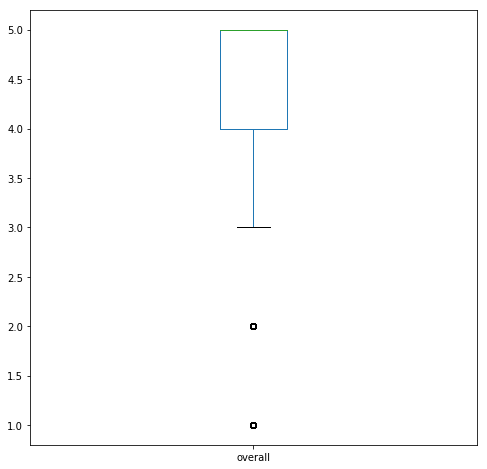

In [8]:
video_games.boxplot(column=['overall'], figsize=(8, 8), grid=False)

We can see that there is definitely more high grades (4, 5) than low ones. Let's describe data to get some insights.

In [9]:
video_games.overall.describe()

count    231780.000000
mean          4.086397
std           1.202330
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: overall, dtype: float64

We have 231780 reviews, with a mean of 4.08 and a standard deviation of 1.20.

When focusing at **robust statistics** only, we can see that the median is 5, and more than 75% of the reviews have awarded 4 or 5 grade to the product.

Let's see data distribution using a bar plot:

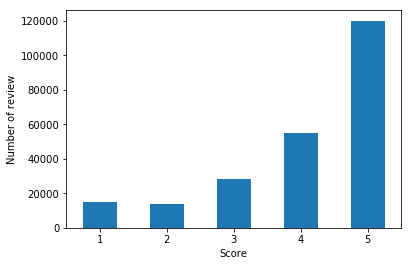

In [10]:
plt.xlabel('Score')
plt.ylabel('Number of review')
video_games.overall.value_counts(ascending=True).sort_index().plot(kind='bar', rot=0)

This confirms what was found before. We can do some assumptions about this distribution:

- The people may be more likely to thank the product quality by posting a review than to say their displeasure
- Amazon sell more good quality product (here video game) than bad one
- The 5 stars review can be due to the presence of fakes/paid review

We also can see that there are more reviews with `1` grade than `2`. This could be understood as people underrating products when they are not fully satisfied. It may also be used by customers to counterbalance a too high grade on a product, based on their opinions.

We now count the number of reviews per product to see if products are equally reviewed:

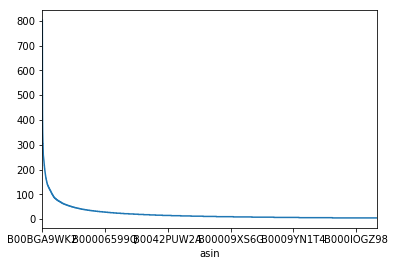

In [11]:
reviews_count_per_product = video_games.groupby(['asin']).overall.count().sort_values(ascending=False)

reviews_count_per_product.plot()

We seem to have a power law. However when using a logarithmic plot, we can see it is not:

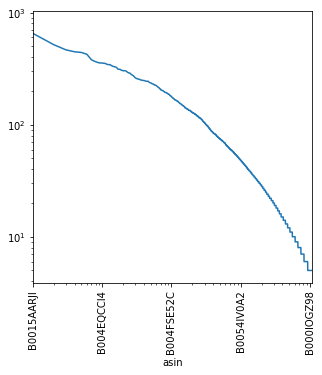

In [12]:
warnings.simplefilter('ignore') # Ignoring warning about non positive xlimit

reviews_count_per_product.plot(logy=True, logx=True, rot=90, figsize=(5, 5))

Let's see if users tend to review products when they are pricy:

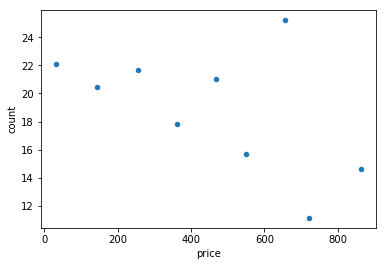

In [13]:
nb_reviews_per_product = pd.DataFrame()

# We count the number of reviews per product
nb_reviews_per_product['count'] = video_games[video_games.price > 0].groupby('asin').overall.count()
# We also add the product price
nb_reviews_per_product['price'] = video_games[video_games.price > 0].groupby('asin').price.mean()

# We create price beans because we have more products in specific price ranges
bins = range(0, 1000, 100)
nb_reviews_per_product['price_group'] = pd.cut(nb_reviews_per_product['price'], bins, labels=range(1, 10))#.plot(kind='scatter', x='price', y='count')

nb_reviews_per_product.groupby(['price_group']).mean().plot(kind='scatter', x='price', y='count')

We can't conclude much here. We can see a spike around 600$ which is due to existing game consoles at this price range, which are clearly more popular.

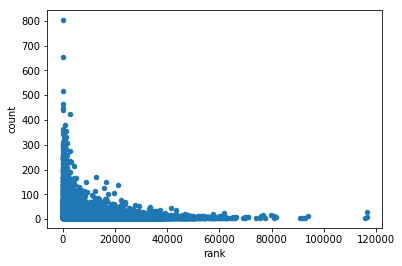

In [14]:
nb_reviews_per_product = pd.DataFrame()

nb_reviews_per_product['count'] = video_games.groupby('asin').overall.count()
nb_reviews_per_product['rank'] = video_games.groupby('asin').rank.mean()

nb_reviews_per_product.plot(kind='scatter', x='rank', y='count')

In [15]:
# We use spearman correlation here because we definitely
# can't have a linear relation between the two based on above graph
nb_reviews_per_product.corr(method='spearman') 

,count,rank
count,1.000000,-0.443484
rank,-0.443484,1.000000


Results seems logical, if a product is well-ranked, it is most likely because it has a lot of reviews, and has actually being purchased. The correlation is however weak as it only concerns the maximum number of reviews. We can still find high ranked products with few reviews.

Let's focus on the most reviewed product. The product is the "PlayStation 4 500GB Console". Notice that the price is not logical. After verification, there was no issue with the data importation. We will have to proceed with caution when using it as a feature.

In [16]:
most_reviewed = reviews_count_per_product.index[0]
most_reviewed_reviews = video_games.loc[most_reviewed]

most_reviewed_reviews.head()

,overall,reviewText,reviewerName,summary,date,helpfulRate,helpfulCount,rank,description,price,title,brand
reviewerID,,,,,,,,,,,,
A386ZNRX0TFFHX,4,I gave it 4 out of 5 stars because of lack of ...,NaN,"Great System, But...",2013-12-18,0.727273,11,13,,28.12,,
A2QYAFX7OCNRMO,3,PlayStation 4 is kind of hard to review right ...,NaN,Has potential...,2014-03-05,0.727273,11,13,,28.12,,
A3OQ3DU03L2GGO,5,Simply amazing. A huge step up from the PS3 an...,NaN,Stunning.,2013-12-01,0.727273,11,13,,28.12,,
A3H99DFEG68SR,3,So I've had the PS4 since launch and I have to...,1m2,I guess I expected more,2014-03-21,-1.000000,0,13,,28.12,,
A15LG7HS4WKKKS,5,Huge overall improvement over the PS3. The use...,"A. A. BADER ""Q8 AL BADER""","Best purchase all year.,",2014-03-06,0.700000,10,13,,28.12,,


We try to see if there are any trends in the reviews over time:

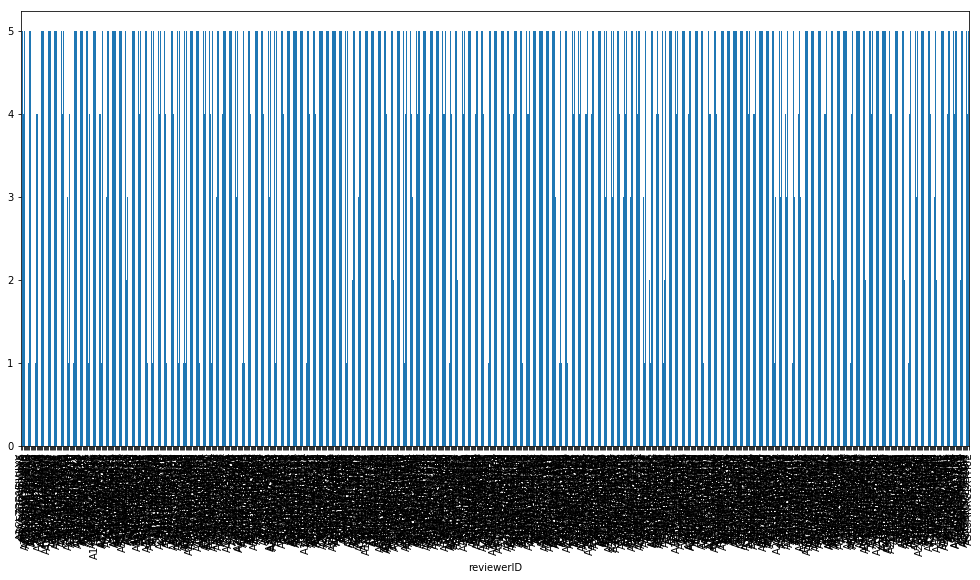

In [17]:
most_reviewed_reviews.sort_values(by=['date'], inplace=True)
most_reviewed_reviews.overall.plot(kind='bar', figsize=(17, 8), rot=90);

It is impossible to visually see any kind of trend. However, it may be possible using machine learning to determine if some grades can be deducted from the previous ones.

### Distribution of helpful rates

We do the same analysis for the helpful rate (after removing the reviews without evaluation):

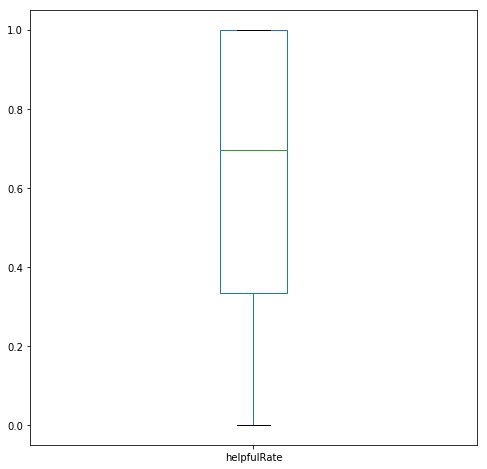

In [18]:
video_games[video_games.helpfulRate >= 0].boxplot(column=['helpfulRate'], figsize=(8, 8), grid=False);

Here, we can see rates are more widely distributed, let's do the same description as before.

In [19]:
video_games[video_games.helpfulRate >= 0].helpfulRate.describe()

count    139855.000000
mean          0.622347
std           0.369065
min           0.000000
25%           0.333333
50%           0.695652
75%           1.000000
max           1.000000
Name: helpfulRate, dtype: float64

Distribution seems more balanced, since first quartile is 0.33, median is 0.69 and last quartile is 0.75. We may however do the assumption that helpful reviews are more likely to be evaluated as even more helpful as Amazon will display those reviews first.

We now look at the distribution of helpful rates, considering all the sold products.

60.34% of reviews are evaluated


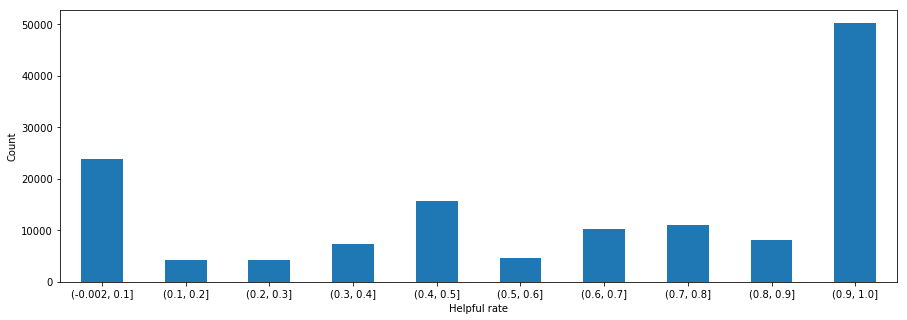

In [20]:
# We get all the "helpfulness rates" (removing the unrated comments)
helpfulRates = video_games[video_games.helpfulRate >= 0].helpfulRate

print(str(round(len(helpfulRates) * 100 / len(video_games.helpfulRate), 2)) + '% of reviews are evaluated')

plt.xlabel('Helpful rate')
plt.ylabel('Count')
helpfulRates.value_counts(ascending=True, bins=10).sort_index().plot(kind='bar', rot=0, figsize=(15, 5));

We can see two outsiders for reviews with less than 10% positive reviews and more than 90% positive reviews. This could be explained by the assumption made previously: the more a review is well rated, the more it is likely to get good rates. In the contrary, reviews with bad rates may be less visible on Amazon and may keep their low rates.

We will now sort the reviewers based on their helpful rate mean, to see if there are some top reviewers or very bad ones.

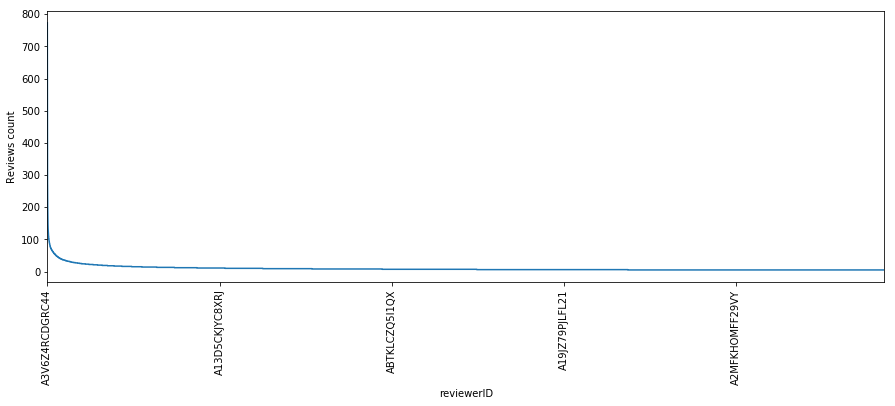

In [21]:
count_evaluations = video_games.groupby('reviewerID').overall.count().sort_values(ascending=False)

plt.ylabel('Reviews count')
count_evaluations.plot(rot=90, figsize=(15, 5));

In [22]:
count_evaluations.describe()

count    24303.000000
mean         9.537094
std         12.789697
min          5.000000
25%          5.000000
50%          7.000000
75%         10.000000
max        773.000000
Name: overall, dtype: float64

We try to zoom to get only evaluators with more than 30 evaluations. We can see that evaluations are done by a restricted number of evaluators providing the majority of evaluations.

1st best evaluator: 773
2nd best evaluator: 635
3rd best evaluator: 456
4th best evaluator: 450
5th best evaluator: 404
6th best evaluator: 320
7th best evaluator: 272
8th best evaluator: 268
9th best evaluator: 224
10th best evaluator: 220


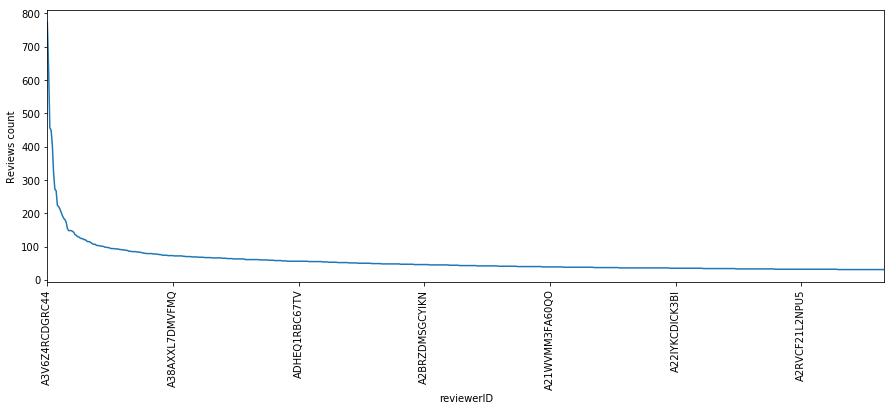

In [23]:
top_count_evaluations = count_evaluations[count_evaluations > 30]
plt.ylabel('Reviews count')
top_count_evaluations.plot(rot=90, figsize=(15, 5))

print('1st best evaluator: ' + str(top_count_evaluations[0]))
print('2nd best evaluator: ' + str(top_count_evaluations[1]))
print('3rd best evaluator: ' + str(top_count_evaluations[2]))
print('4th best evaluator: ' + str(top_count_evaluations[3]))
print('5th best evaluator: ' + str(top_count_evaluations[4]))
print('6th best evaluator: ' + str(top_count_evaluations[5]))
print('7th best evaluator: ' + str(top_count_evaluations[6]))
print('8th best evaluator: ' + str(top_count_evaluations[7]))
print('9th best evaluator: ' + str(top_count_evaluations[8]))
print('10th best evaluator: ' + str(top_count_evaluations[9]))

We seem to have a power law here. We try to confirm this using a logarithmic plot:

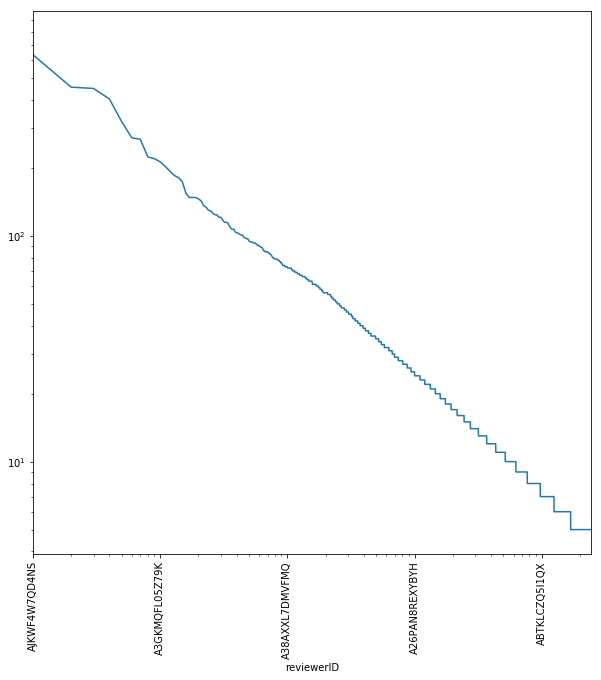

In [24]:
warnings.simplefilter('ignore') # Ignoring warning about non positive xlimit

count_evaluations.plot(logy=True, logx=True, rot=90, figsize=(10, 10));

We indeed have a power law.

### Analysis of the more productive reviewer

Focusing on the best evaluator, let's see if he provides well rated evaluations:

In [25]:
best_reviewer_id = top_count_evaluations.index[0]

print('Number of reviews: ' + str(video_games.groupby('reviewerID').get_group(best_reviewer_id).overall.count()))
video_games.groupby('reviewerID').get_group(best_reviewer_id).median()

Number of reviews: 773


overall            5.000000
helpfulRate        0.888889
helpfulCount       9.000000
rank            8736.000000
price             29.990000
dtype: float64

Comparing it with the other reviewers:

In [26]:
video_games.overall.median()

5.0

In [27]:
video_games[video_games.helpfulRate >= 0].helpfulRate.median()

0.6956521739130435

The best evaluator seems to be a normal person, his `helpfulRate` is above to the median (allowing to believe he does not flooded the products with fake reviews). He also gave more than 50% of 5 star grades. We don't get a lot of information here.

## Correlations

We add columns `reviewLength`, `summaryLength` and `reviewerNameLength` to the dataframe to take into account more metrics.

In [28]:
video_games['reviewLength'] = video_games['reviewText'].str.len()
video_games['summaryLength'] = video_games['summary'].str.len()
video_games['reviewerNameLength'] = video_games['reviewerName'].str.len()

video_games.head()

overall  \
asin       reviewerID                
0700099867 A2HD75EMZR8QLN        1   
           A3UR8NLLY1ZHCX        4   
           A1INA0F5CWW3J4        1   
           A1DLMTOTHQ4AST        3   
           A361M14PU2GUEG        4   

                                                                  reviewText  \
asin       reviewerID                                                          
0700099867 A2HD75EMZR8QLN  Installing the game was a struggle (because of...   
           A3UR8NLLY1ZHCX  If you like rally cars get this game you will ...   
           A1INA0F5CWW3J4  1st shipment received a book instead of the ga...   
           A1DLMTOTHQ4AST  I got this version instead of the PS3 version,...   
           A361M14PU2GUEG  I had Dirt 2 on Xbox 360 and it was an okay ga...   

                                                 reviewerName  \
asin       reviewerID                                           
0700099867 A2HD75EMZR8QLN                                 123   
           A3UR8NLLY1ZHCX  Alejandro Henao "Electronic Junky"   
           A1INA0F5CWW3J4          Amazon Shopper "Mr.Repsol"   
           A1DLMTOTHQ4AST                            ampgreen   
           A361M14PU2GUEG        Angry Ryan "Ryan A. Forrest"   

                                                                   summary  \
asin       reviewerID                                                        
0700099867 A2HD75EMZR8QLN         Pay to unlock content? I don't think so.   
           A3UR8NLLY1ZHCX                                  Good rally game   
           A1INA0F5CWW3J4                                        Wrong key   
           A1DLMTOTHQ4AST  awesome game, if it did not crash frequently !!   
           A361M14PU2GUEG                                           DIRT 3   

                                date  helpfulRate  helpfulCount  rank  \
asin       reviewerID                                                   
0700099867 A2HD75EMZR8QLN 2012-07-09     0.666667            12  6629   
           A3UR8NLLY1ZHCX 2013-06-30    -1.000000             0  6629   
           A1INA0F5CWW3J4 2014-06-28    -1.000000             0  6629   
           A1DLMTOTHQ4AST 2011-09-14     0.700000            10  6629   
           A361M14PU2GUEG 2011-06-14     1.000000             2  6629   

                                                                 description  \
asin       reviewerID                                                          
0700099867 A2HD75EMZR8QLN  Dirt 3 is a popular rally racing game for Play...   
           A3UR8NLLY1ZHCX  Dirt 3 is a popular rally racing game for Play...   
           A1INA0F5CWW3J4  Dirt 3 is a popular rally racing game for Play...   
           A1DLMTOTHQ4AST  Dirt 3 is a popular rally racing game for Play...   
           A361M14PU2GUEG  Dirt 3 is a popular rally racing game for Play...   

                            price title brand  reviewLength  summaryLength  \
asin       reviewerID                                                        
0700099867 A2HD75EMZR8QLN  246.63                       779             40   
           A3UR8NLLY1ZHCX  246.63                       304             15   
           A1INA0F5CWW3J4  246.63                       282              9   
           A1DLMTOTHQ4AST  246.63                      3489             47   
           A361M14PU2GUEG  246.63                       294              6   

                           reviewerNameLength  
asin       reviewerID                          
0700099867 A2HD75EMZR8QLN                 3.0  
           A3UR8NLLY1ZHCX                34.0  
           A1INA0F5CWW3J4                26.0  
           A1DLMTOTHQ4AST                 8.0  
           A361M14PU2GUEG                28.0

Before displaying the correlations, let's study how review's length are distributed (we only take into account reviews with at least one word).

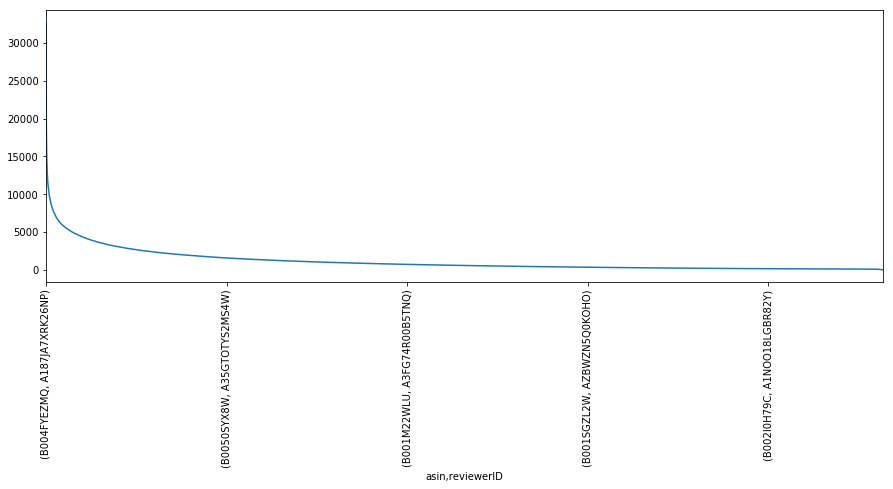

In [29]:
reviews_length = video_games[video_games.reviewLength > 0].reviewLength.sort_values(ascending=False)
reviews_length.plot(rot=90, figsize=(15, 5))

In [30]:
reviews_length.describe()

count    231736.000000
mean       1134.122294
std        1567.257313
min           3.000000
25%         235.000000
50%         576.000000
75%        1373.000000
max       32689.000000
Name: reviewLength, dtype: float64

As we can see, 50% of reviews have less than 576 words and 75% have less than 1373 words.

We display the correlation matrix and scatter plot:

In [31]:
video_games.corr()

,overall,helpfulRate,helpfulCount,rank,price,reviewLength,summaryLength,reviewerNameLength
overall,1.000000,-0.133272,-0.086515,-0.103580,0.054490,-0.062702,-0.074935,-0.009817
helpfulRate,-0.133272,1.000000,0.121019,0.111745,0.024150,0.294168,0.176459,0.099481
helpfulCount,-0.086515,0.121019,1.000000,-0.004194,0.007926,0.132578,0.056006,0.024202
rank,-0.103580,0.111745,-0.004194,1.000000,-0.044552,0.025594,0.024803,0.068892
price,0.054490,0.024150,0.007926,-0.044552,1.000000,0.018522,0.021716,0.011590
reviewLength,-0.062702,0.294168,0.132578,0.025594,0.018522,1.000000,0.309686,0.098275
summaryLength,-0.074935,0.176459,0.056006,0.024803,0.021716,0.309686,1.000000,0.094534
reviewerNameLength,-0.009817,0.099481,0.024202,0.068892,0.011590,0.098275,0.094534,1.000000


We plot the scatter matrix for each columns to avoid to fall in some bias (e.g. Simpson's paradox) by just looking at the correlation table.

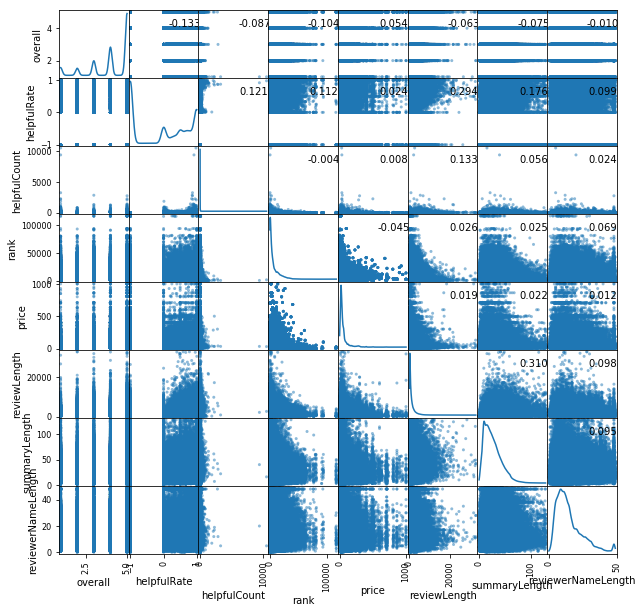

In [32]:
from pandas.tools.plotting import scatter_matrix

axes = scatter_matrix(video_games, alpha=0.5, diagonal='kde', figsize=(10, 10))
corr = video_games.corr().as_matrix()
for i, j in zip(*plt.np.triu_indices_from(axes, k=1)):
    axes[i, j].annotate("%.3f" %corr[i,j], (0.8, 0.8), xycoords='axes fraction', ha='center', va='center')

plt.show()

- There is some correlation between between `reviewLength` and the `helpfulRate`. We can think that more the `reviewLength` is high, more the review can contain more descriptions and arguments, so it can increase the helpfullness.   
- Then, the `summaryLength` and the `reviewLength` seems to be also correlated. The more the review text is lengthy, the more the summary needs letters to summarize it.

## Serialize video_games using pickle

In [33]:
import pickle

with open('pickle/video_games.pkl', 'wb') as output:
    pickle.dump(video_games, output, pickle.HIGHEST_PROTOCOL)

## Words occurences

To do our `reviewText` words occurences, we will use the product which has the most reviews "PlayStation 4 500GB Console"

### Unigram

We print the top 10 words for each review grouped by the overall score.

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

def get_top_words(text_series, ngram):
    word_vectorizer = CountVectorizer(ngram_range=(ngram, ngram), analyzer='word', stop_words='english')
    sparse_matrix = word_vectorizer.fit_transform(text_series)
    frequencies = sum(sparse_matrix).toarray()[0]
    bigrams_freq = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency']).sort_values(by=['frequency'], ascending=False)

    bigrams_freq = bigrams_freq.iloc[0:10]

    return bigrams_freq.index


top_words_per_overall = pd.DataFrame()

for i in range(5):
    top_words_per_overall["Score " + str(i+1)] = get_top_words(most_reviewed_reviews[most_reviewed_reviews.overall == (i+1)].reviewText, 1)
top_words_per_overall

,Score 1,Score 2,Score 3,Score 4,Score 5
0,ps4,ps4,ps4,ps4,ps4
1,sony,games,games,games,games
2,console,ps3,ps3,like,console
3,just,sony,sony,controller,controller
4,xbox,console,like,game,ps3
5,amazon,just,just,ps3,game
6,games,play,console,just,like
7,34,like,game,console,xbox
8,work,does,play,sony,great
9,like,really,controller,better,just


The words are kind of neutral, there is not real positive or negative sentiment word. Except for "great" for Score 5 but only at 9th position. We were waiting for the postive word to be more in Score 5 and negative Score 1. The top word for each overall score is "ps4" which is the product name.

But only one word can miss some context, it's a better idea to search for multiple words.

### Bigram

So we now display the top bigram

In [35]:
top_words_per_overall = pd.DataFrame()
for i in range(5):
    top_words_per_overall["Score " + str(i+1)] = get_top_words(most_reviewed_reviews[most_reviewed_reviews.overall == (i+1)].reviewText, 2)
top_words_per_overall

,Score 1,Score 2,Score 3,Score 4,Score 5
0,blue light,blu ray,touch pad,hard drive,xbox 360
1,safe mode,ps3 ps4,hard drive,play games,free games
2,hard drive,steam pc,ps4 does,free games,user interface
3,doesn work,firmware update,ps3 ps4,new controller,hard drive
4,light death,looking forward,like ps3,blu ray,remote play
5,customer service,incremental services,blu ray,xbox 360,games like
6,blinking blue,pc games,better ps3,games like,games look
7,59 99,ps2 ps3,sony support,remote play,ps plus
8,xbox ps4,ability play,looks like,blue light,play games
9,launch day,usb port,feel like,just like,blu ray


Unfortunately, two words does not capture the sentiment of the review. The most of the outputed bigram are just common nouns. We can't say by having just "xbox 360" or "blue light" determine if the score will be 5 or 1.

## Machine learning exploratory

We now use some machine learning methods to improve our analysis.

### TF-IDF 
We transform the review text to TF-IDF features to to the clustering

In [36]:
vectorizer = TfidfVectorizer(stop_words = 'english', min_df=5)
tfidf_matrix = vectorizer.fit_transform(most_reviewed_reviews.reviewText)

#### Clustering attempt

We try to determine if the occurences of certain word are specific to the a certain score. We try to cluster, using unsupervised learning, the reviews based on the tf-idf features to 5 groups. We hope we will find on each group the same overall score : 1 group for review score 1, another for score 2 etc...

##### KMeans

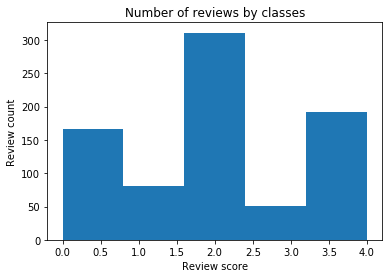

In [37]:
from sklearn.cluster import KMeans

k = 5
km = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=5)
km.fit(tfidf_matrix)

plt.hist(km.labels_, bins=k)
plt.xlabel('Review score')
plt.ylabel('Review count')

plt.title('Number of reviews by classes')
plt.show()

In [38]:
clusters = {}

for i in set(km.labels_):
    cluster = [most_reviewed_reviews.iloc[x] for x in np.where(km.labels_ == i)[0]]
    clusters[i] = pd.DataFrame(cluster)

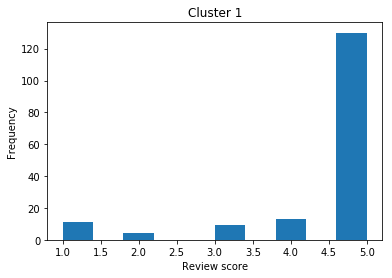

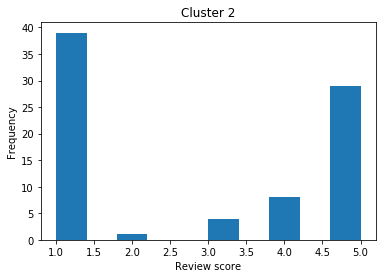

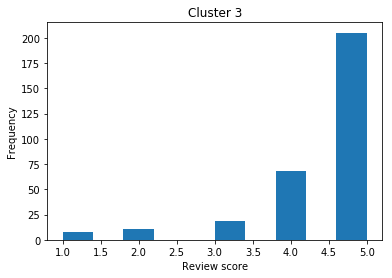

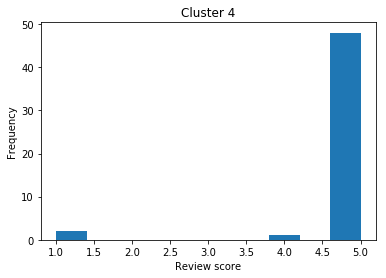

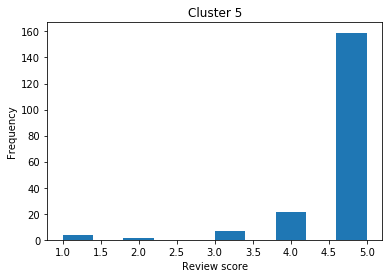

In [39]:
plt.title("Cluster 1")
plt.xlabel('Review score')
clusters[0].overall.plot(kind="hist");
plt.show()

plt.title("Cluster 2")
plt.xlabel('Review score')
clusters[1].overall.plot(kind="hist");
plt.show()

plt.title("Cluster 3")
plt.xlabel('Review score')
clusters[2].overall.plot(kind="hist");
plt.show()

plt.title("Cluster 4")
plt.xlabel('Review score')
clusters[3].overall.plot(kind="hist");
plt.show()

plt.title("Cluster 5")
plt.xlabel('Review score')
clusters[4].overall.plot(kind="hist");
plt.show()

It's not a great success. We dont have in each cluster only review with same score, but a mix. TF-IDF is unstable for such short document lengths.

For milestone 3, we will use the StarSpace embeddings instead of TF-IDF.

## Next milestone

### Regression model

#### Linear regression

We will now try to do some `helpfulRate` prediction using simple linear regression. We start by producting a scatter plot based on the insights we found previously. More precisely, we will here visualize the `helpfulRate` compared to the `reviewLength` to see if we can visually anticipate a linear correlation between the two:

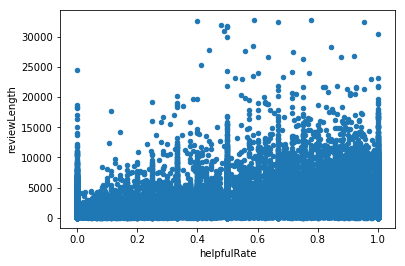

In [40]:
video_games[video_games.helpfulRate >= 0].plot(kind='scatter', x='helpfulRate', y='reviewLength')

We can see that it does not seem to have an explicit linear correlation here. We can still do the linear regression, as it is simple to implement. We, however, expect poor result here.

In [41]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score

lreg = linear_model.LinearRegression()

X = video_games[video_games.helpfulRate >= 0].loc[:,['reviewLength', 'summaryLength', 'rank', 'overall']]
x_train, x_cv, y_train, y_cv = train_test_split(X,video_games[video_games.helpfulRate >= 0].helpfulRate)

lreg.fit(x_train,y_train)
pred = lreg.predict(x_cv)

explained_variance_score(y_cv, pred)

0.11529731263545873

After several testings on multiple features, we found the best features combination to get a `variance score` of about 0.12. This is a really poor result considering the best possible score is 1.0.

#### Neural networks

Considering the data distribution, usage of linear regression seems to be innapropriate. We chose to change completely our strategy by using neural networks. As we have important data aggregates, we may succeed in training a neural network to predict helpful rates.

We start by a naive approach, by trying to predict if a review was helpful only using the `overall` feature; meaning answering the question: "How well can we predict if a review is helpful based on the review grade?"

In [42]:
def train_network(dataset, features, max_iter):
    y = dataset['wasHelpful']
    x = dataset.loc[:, features]

    x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.25)

    clf = MLPClassifier(hidden_layer_sizes=(100,100,100), max_iter=max_iter, alpha=0.0001,
                     solver='sgd', verbose=False,  random_state=21, tol=0.000000001)

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)

    print(accuracy_score(y_test, y_pred))
    
    return clf, x, y

In [43]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# We only analyse reviews with an helpful rate...
helpful_video_games = video_games[video_games.helpfulRate >= 0]

# We also take only reviews with a minimum of three evaluations, to avoid bias
helpful_video_games = helpful_video_games[video_games.helpfulCount > 3]

# We clusterize our data into two categories: helpful and non-helpful reviews
helpful_video_games['wasHelpful'] = helpful_video_games.helpfulRate >= 0.5
    
clf, x, y = train_network(helpful_video_games, ['overall'], 20)

0.73816940218


The accuracy score is around 0.7 by only taking into account the initial rate, which is clearly better than a simple linear regression. Let's find out how our classifier works...

In [44]:
for i in range(1, 6):
    print(str(i) + ' star review: ' + str(clf.predict(i)))

1 star review: [False]
2 star review: [ True]
3 star review: [ True]
4 star review: [ True]
5 star review: [ True]


We get here a new insight about data distribution. One start reviews seems to have a lower helpful rate than other reviews. This may be due to overstated reviews and product bashing. Let's do a short descriptive analysis to confirm this new information.

Because we know we have high differences in the number of evaluations in each grade category, we use the standard error instead of the standard deviation to draw the error bars. This allows to mitigate the observations.

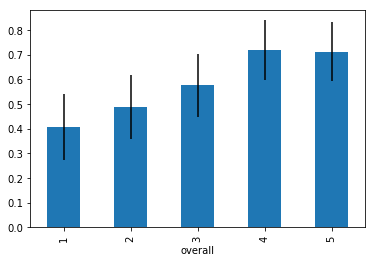

In [45]:
grouped_helpful_reviews = helpful_video_games.groupby(['overall']).helpfulRate
grouped_helpful_reviews.mean().plot(kind='bar', yerr=grouped_helpful_reviews.std()/math.sqrt(len(grouped_helpful_reviews)))

We can see that errors are important, due to the high variance of the results. This may be explained by the fact that using the overall only to find the final rank is not as good as taking multiple features into account.

After seing this plot and data distribution, we can understand why only 1 star reviews are getting are immediately considered as not helpful. We now cross validate to ensure results were representative of the reality.

In [46]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, x, y, cv=3, scoring='f1')
scores

array([ 0.84719601,  0.8180094 ,  0.82466259])

After cross-validation, we get even better results with an accuracy around 0.8. However, predicting the helpfulness of a review by sorting it as `true` or `false` based on the grade is not very helpful and creates an unwanted segregation in data. Considering Amazon would use these results to promote specific reviews, it may create an incentive for posting fake 5 star reviews to be put forward.

Before testing against more features, we will create three clusters to determine if a review was helpful:

- 0 will mean the review is not helpful at all (less than 33% of the evaluations said it was useful)
- 1 will mean the review may be polemical (less than 66% of the evaluations said it was useful)
- 2 will mean the review was useful (more than 66% of the evaluations said it was useful)

In [47]:
helpful_video_games2 = helpful_video_games.copy()
helpful_video_games2['wasHelpful'] = helpful_video_games.helpfulRate.map(lambda x: 0 if x < 0.33 else 1 if x < 0.66 else 2)

clf, x, y = train_network(helpful_video_games2, ['overall'], 100)

0.573140050317


The accuracy of our network dropped significantly. Let's find out how he classified our data:

In [48]:
for i in range(1, 6):
    print(str(i) + ' star review: ' + str(clf.predict(i)))

1 star review: [0]
2 star review: [2]
3 star review: [2]
4 star review: [2]
5 star review: [2]


We can see that our neural networks is limited here, and have some difficulties determining when the reviews should be "polemical". We will now introduce more features to see if we can improve our accuracy score which dropped a lot.

In [49]:
# We increase the number of iterations as we have a higher scope of possibilities
clf, x, y = train_network(helpful_video_games2, ['reviewLength'], 1000)
scores = cross_val_score(clf, x, y, cv=3)
scores

0.547801605367


array([ 0.54490319,  0.54488274,  0.54490722])

In [50]:
for i in range(0, 100000):
    if clf.predict(i)[0] != 2:
        print(i)

We can see with the previous code that our classifer always return *2* as the level of helpfulness of the review; it does not find any trend in the dataset.

By using only the review length, we get a really lower range. It is not possible, only considering the review length, to determine if it would be helpful. We will need to go deeper and analyse the review contents.

In [55]:
clf, x, y = train_network(helpful_video_games2, ['summaryLength'], 1000)
scores = cross_val_score(clf, x, y, cv=3)
scores

last_i = 0
for i in range(0, 32689):
    prediction = clf.predict(i)
    if prediction[0] != 2:
        print(str(i) + ' characters: ' + str(prediction[0]))
        last_i = i

print(str(last_i+1) + ' characters: 2')

0.545225829639
0 characters: 0
1 characters: 0
2 characters: 0
3 characters: 0
4 characters: 0
5 characters: 2


Using only the summary length, only summary with a length inferior than about 5 are considered as *bad* and get a 0 score. We still don't get any polemical reviews.

### Usage of StarSpace to analyse reviews

Using StarSpace, we will try to determine if some words may allow to predict helpfulness of reviews.

#### Based on a reviewer

This study will be done based on some of the most productive reviewers.

#### Based on a product

This study will also be done based on some specific products with a lot of reviews. If we don't have enought reviews associated with the product, we may use similar products (using knl algorithm).

#### Analysis of short reviews

We will use the study to determine if some aspects of *short* reviews are determinant for the final helpfulness rate.

### Reviews history

We will analyse reviews history to determine if some conclusions can be done concerning the Social proof.

Depending on how much time we will spend, we may extend the above analysis to determine reviews grades.